# Set up and module imports


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import pandas as pd


# Import Data + Clean Data
def importCleanData(file_name, sheet, columns):
    data = pd.read_excel(file_name, sheet_name = sheet)
    cleanData = data.loc[:, columns].dropna()
    return cleanData

# Change the working directory 
print(os.getcwd()) # Prints the current working directory
# directories 
justin = 'C:/Users/dhlpablo_m2/Desktop/Git/Data_extraction_kinetic_signaling_data/data/train_data/vegf_testdata'
Lionel = 'C:/Users/Imoukhuede lab/OneDrive - UW/Desktop/GitHub/Data_extraction_kinetic_signaling_data/data/train_data/vegf_testdata'
# Provide the new path here
os.chdir(justin) 
# Prints the new working directory
print(os.getcwd())




/workspaces/Data_extraction_kinetic_signaling_data/code/python


FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/dhlpablo_m2/Desktop/Git/Data_extraction_kinetic_signaling_data/data/train_data/vegf_testdata'

## Importing the data from the csv file

In [4]:
# Import Data
testFile1 = pd.read_excel("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", sheet_name = "sheet1")
testFile105 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 0.5nM", "RU 0.5nM"])
testFile11 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 1nM", "RU 1nM"])

## Defining the Individual Functions
These are the fitting equations that will be used to predict data

# Function Building

In [5]:
# Function 1: Baseline falling to steady state response
def baseline_steadystate_response(t, y_initial, y_final, kon):
    """
    Function to find the kon value from the data. 
    Assuming we know the baseline and the steady state response, we can find the kon value.
    The equation is y(t) = y_final * (1 - exp(-kon * t)) + y_intial

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing the time and response values
    y_intial : float
        The baseline value of the response
    y_final : float
        The steady state value of the response
    t : float
        The time value

    Returns
    -------
    function
        The function that can be used to calculate the response
    """
    return y_final * (1 - np.exp(-kon * t)) + y_initial

In [6]:
# Function 2: Response falling to zero
def response_to_zero(t, C, y_initial,  kon, koff):
    """
    Function to find the kon and koff values from the data
    Assuming we know that the response goes to zero

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing the time and response values
    C : float
        The initial rate of signaling
    y_initial : float
        The baseline value of the response
    t : float
        The time value
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    return (C / (kon - koff)) * (np.exp(-koff * t) - np.exp(-kon * t)) + y_initial


In [7]:
# Function 3: Response falling to steady state response
def response_to_steady_state(t, y_initial, y_final,  D, kon, koff):
    """
    Function to find the kon and koff values from the data
    Assuming we know the steady state response

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing thetime and response values
    y_initial : float
        The initial rate of signaling
    y_final : float
        The final rate of signaling
    t : float
        The time value
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    return y_final * ( 1 - D * np.exp(-kon * t) + (D - 1) * np.exp(-koff * t)) + y_initial

In [8]:
# Function 4: Typical association
def typical_association(t, y_final, conc, kon, koff):
    """
    Function to find the kon and koff values from the data
    Assuming it is a typical association function

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing thetime and response values
    y_final : float
        The final rate of signaling
    t : float
        The time value
    conc : float
        The concentration of the substance
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    kd = koff/kon
    return ( (y_final * conc) / (koff/kon + conc) ) * (1 - np.exp( (-1*(kon * conc + koff)) * t) )

In [9]:
# Function 5: Typical dissociation
def typical_dissociation(t, y_initial, koff):
    """
    Function to find the koff values from the data
    Assuming it is a typical dissociation function

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing thetime and response values
    y_initial : float
        The initial rate of signaling
    t : float
        The time value
    
    Returns
    -------
    function
        The function that can be used to calculate the response

    """
    return y_initial * np.exp(-koff * t)

## Overall Function
This is the big function that holds a combination of all the fitting equations used

In [10]:
# Fitting the data to its appropriate function
def fit_data(time, response, p0):
    """
    Function to fit the data to the function

    Parameters
    ----------
    data : pandas dataframe
        Dataframe containing the time and response values
    function : function
        The function that will be used to fit the data

    Returns
    -------
    param_k
        The parameters of the function
    pcov_k  
        The covariance of the parameters
    """

    assumption = "response to zero"
    if assumption == "baseline+steadystate":
        def baseline_steadystate_response(t, y_initial, y_final, kon):
            """
            Function to find the kon value from the data. 
            Assuming we know the baseline and the steady state response, we can find the kon value.
            The equation is y(t) = y_final * (1 - exp(-kon * t)) + y_intial

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing the time and response values
            y_intial : float
                The baseline value of the response
            y_final : float
                The steady state value of the response
            t : float
                The time value

            Returns
            -------
            function
                The function that can be used to calculate the response
            """
            return y_final * (1 - np.exp(-kon * t)) + y_initial
        function = baseline_steadystate_response
        param_k, pcov_k = curve_fit(function, time, response, p0 = [y_initial, y_final, kon])

    elif assumption == "response to zero":
        def response_to_zero(t, C, y_initial, kon, koff):
            """
            Function to find the kon and koff values from the data
            Assuming we know that the response goes to zero

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing the time and response values
            C : float
                The initial rate of signaling
            y_initial : float
                The baseline value of the response
            t : float
                The time value
            
            Returns
            -------
            function
                The function that can be used to calculate the response

            """
            return (C / (kon - koff)) * (np.exp(-koff * t) - np.exp(-kon * t)) +y_initial
        
        function = response_to_zero
        param_k, pcov_k = curve_fit(function, time, response, p0 = [C, y_initial, kon, koff])

    elif assumption == "response to steady state":
        def response_to_steady_state(t, y_initial, y_final, D, kon, koff):
            """
            Function to find the kon and koff values from the data
            Assuming we know the steady state response

            Parameters
            ----------
            data : pandas dataframe
                Dataframe containing thetime and response values
            y_initial : float
                The initial rate of signaling
            y_final : float
                The final rate of signaling
            t : float
                The time value
            
            Returns
            -------
            function
                The function that can be used to calculate the response

            """
            return y_final * ((1 - D * np.exp(-kon * t)) + (D - 1) * np.exp(-koff * t)) + y_initial
        
        function = response_to_steady_state
        param_k, pcov_k = curve_fit(function, time, response, p0 = [y_initial, y_final, D, kon, koff])

    return param_k, pcov_k

# Fitting Function Tests
These are examples and tests to check if equations are working properly

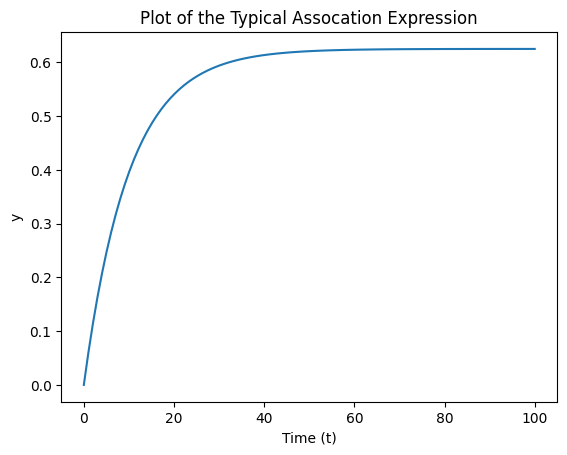

In [11]:
# Example association

# Define the parameters
y_final = 1.0
C = 0.5
k_d = 0.3
k_on = 0.1
k_off = 0.05
t = np.linspace(0, 100, 100)

# Typical Assocation equation
y = (y_final * C / (k_d + C)) * (1 - 1 / np.exp((k_on * C + k_off) * t))

# Plot the results
plt.plot(t, y)
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Typical Assocation Expression')
plt.show()

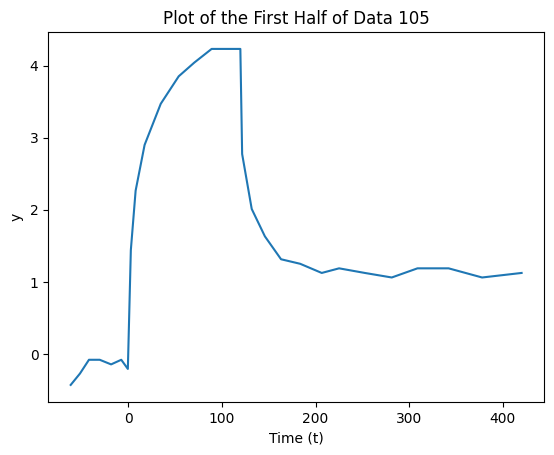

Initial guess:  [np.float64(1.123), 1e-08, 55473110.0, 0.008049]


c:\Users\dhlpablo_m2\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


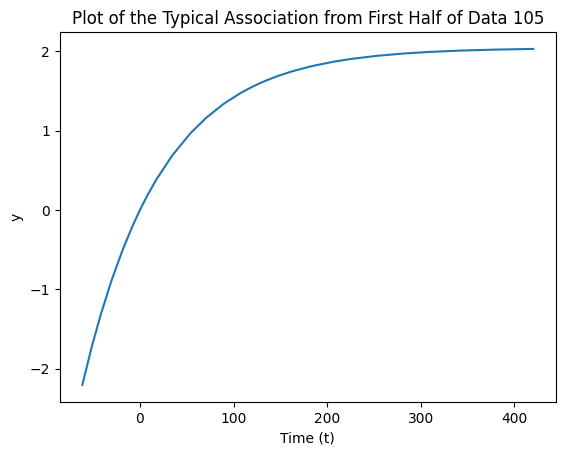

Fitted parameters:  [ 1.83351789e+00  1.18527303e-08  1.11713449e+06 -1.36202729e-03]


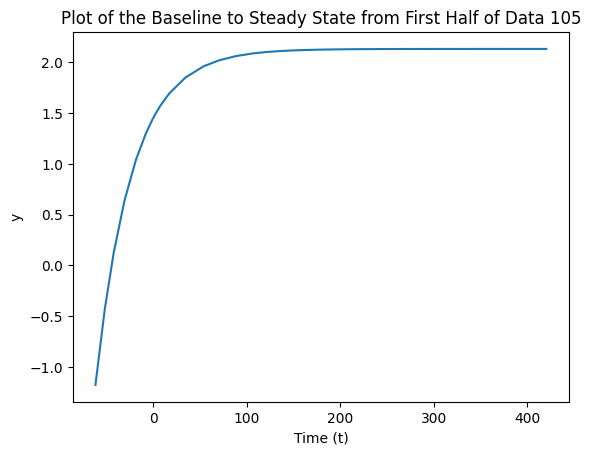

Fitted parameters:  [1.44959296 0.68208765 0.02562391]


In [12]:
# Testing first half of some data with association equation

testFile105 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 0.5nM", "RU 0.5nM"])

# remove the first 4 rows
testFile105 = testFile105.iloc[4:]
testFile105 = testFile105.iloc[:-15]
testFile105

# plot the data
plt.plot(testFile11["Time 1nM"], testFile11["RU 1nM"])
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the First Half of Data 105')
plt.show ()

# plot with typical association equation

# Initial guess for the parameters
y_initial = testFile11.iloc[0, 1]
y_final = testFile11["RU 1nM"].iloc[-1]
initial_guess = [y_final, 10*(10**(-9)) , 5.547311e+07, 0.008049]
print("Initial guess: ", initial_guess)

# Data for the plot
t_data = testFile11["Time 1nM"]
response_data = testFile11["RU 1nM"]
param_k, pcov_k = curve_fit(typical_association, t_data, response_data, p0=initial_guess)
fitted_response= typical_association(testFile11["Time 1nM"], *param_k)

# plot the typical assocation fitted data
plt.plot(testFile11["Time 1nM"], fitted_response, label='Fitted Data')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Typical Association from First Half of Data 105')
plt.show ()
print("Fitted parameters: ", param_k)

# plot with baseline equation

# Initial guess for the parameters
y_initial = testFile11.iloc[0, 1]
y_final = testFile11["RU 1nM"].iloc[-1]  # Extract the single value
initial_guess = [y_initial, y_final, 0.05]

param_k, pcov_k = curve_fit(baseline_steadystate_response, t_data, response_data, p0=initial_guess)

# plot the baseline steady state fitted data 
fitted_response= baseline_steadystate_response(testFile11["Time 1nM"], *param_k)
plt.plot(testFile11["Time 1nM"], fitted_response, label='Fitted Data')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Baseline to Steady State from First Half of Data 105')
plt.show ()
print("Fitted parameters: ", param_k)

In [13]:
testFile11

,Time 1nM,RU 1nM
0,-61.628,-0.431
1,-51.715,-0.273
2,-42.122,-0.082
3,-30.610,-0.082
4,-18.459,-0.146
5,-7.587,-0.082
6,-0.552,-0.209
7,2.645,1.440
8,7.762,2.265
9,17.355,2.900


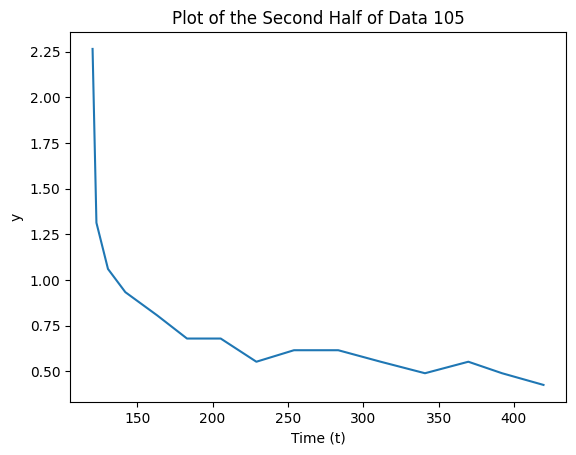

Initial guess:  [np.float64(2.265), 0.008049]
Fitted parameters:  [2.6840188 0.0056251]


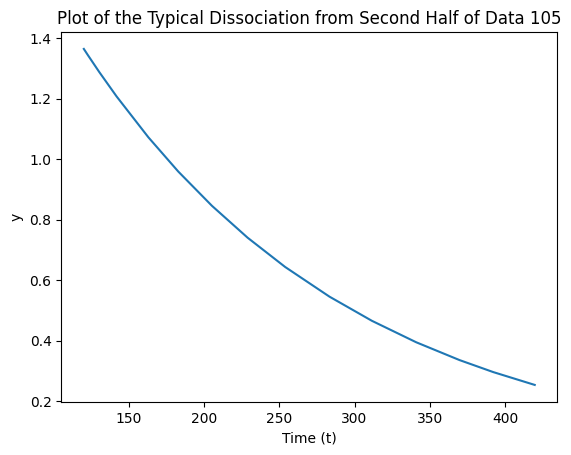

Fitted parameters:  [2.6840188 0.0056251]


In [14]:
# Testing second half of the data with dissocation equation

testFile105 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 0.5nM", "RU 0.5nM"])
# remove the first 4 rows
testFile105 = testFile105.iloc[14:]
testFile105 = testFile105.iloc[:]
testFile105

# plot the data
plt.plot(testFile105["Time 0.5nM"], testFile105["RU 0.5nM"])
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Second Half of Data 105')
plt.show ()

# Initial guess for the parameters
y_initial = testFile105.iloc[0, 1]
y_final = testFile105["RU 0.5nM"].iloc[-1]  # Extract the single value
#initial_guess = [y_initial, y_final, 6e1, 0.5, 1]
initial_guess = [y_initial, 0.008049]
print("Initial guess: ", initial_guess)

# data
t_data = testFile105["Time 0.5nM"]
response_data = testFile105["RU 0.5nM"]

param_k, pcov_k = curve_fit(typical_dissociation, t_data, response_data, p0=initial_guess)
print("Fitted parameters: ", param_k)

# plot the typical dissociation fitted data
fitted_response= typical_dissociation(testFile105["Time 0.5nM"], *param_k)
plt.plot(testFile105["Time 0.5nM"], fitted_response, label='Fitted Data')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Typical Dissociation from Second Half of Data 105')
plt.show ()
print("Fitted parameters: ", param_k)

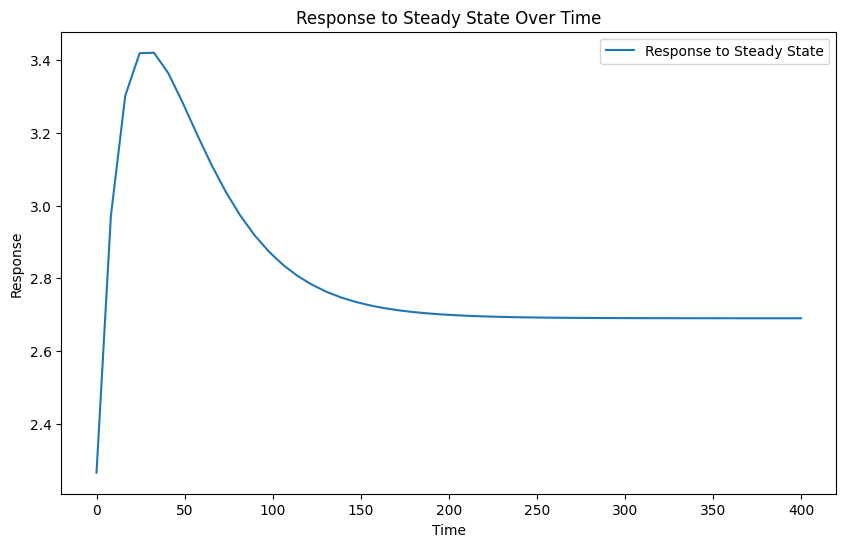

In [15]:
# Example for response to steady state

# Parameters
y_initial = testFile105.iloc[0, 1]
y_final = testFile105["RU 0.5nM"].iloc[-1]  # Extract the single value
D = 10
kon = 0.055
koff = 0.03
t = np.linspace(0, 400)
response = y_final * ( (1 - D * np.exp(-kon * t) ) + ( (D - 1) * np.exp(-koff * t) ) ) + y_initial

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t, response, label='Response to Steady State')
plt.title('Response to Steady State Over Time')
plt.xlabel('Time')
plt.ylabel('Response')
plt.legend()
plt.show()

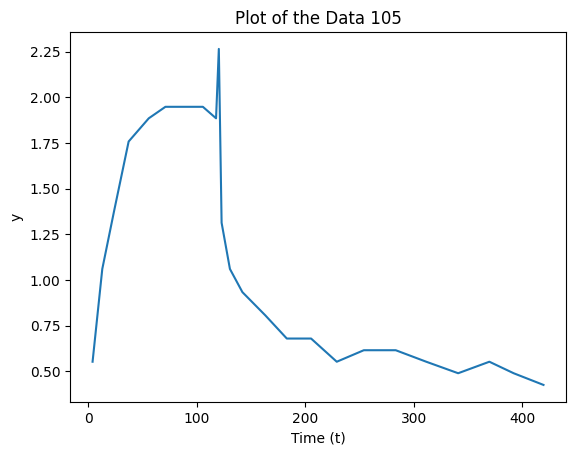

Fitted parameters:  [5.520000e-01 4.250000e-01 1.500000e+00 5.547311e+07 8.049000e-03]


C:\Users\dhlpablo_m2\AppData\Local\Temp\ipykernel_37556\3906726534.py:22: OptimizeWarning: Covariance of the parameters could not be estimated
  param_k, pcov_k = curve_fit(response_to_steady_state, t_data, response_data, p0=initial_guess)


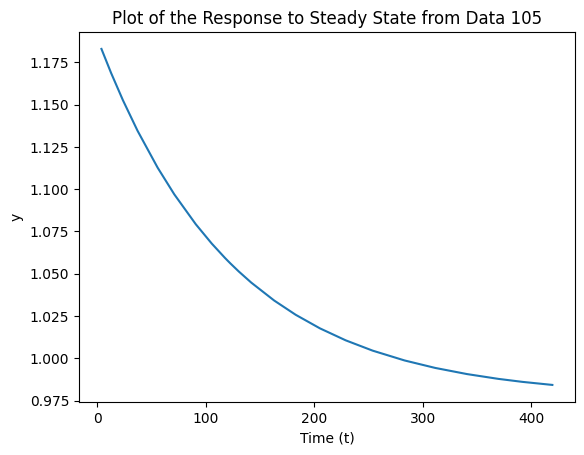

In [16]:
# Testing the full data with response to steady state equation
testFile105 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 0.5nM", "RU 0.5nM"])
# remove the first 4 rows
testFile105 = testFile105.iloc[5:]
testFile105

# plot the data
plt.plot(testFile105["Time 0.5nM"], testFile105["RU 0.5nM"])
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Data 105')
plt.show ()

# Initial guess for the parameters
y_initial = testFile105.iloc[0, 1]
y_final = testFile105["RU 0.5nM"].iloc[-1]  # Extract the single value
initial_guess = [y_initial, y_final, 1.5 , 5.547311e+07, 0.008049]

# data
t_data = testFile105["Time 0.5nM"]
response_data = testFile105["RU 0.5nM"]
param_k, pcov_k = curve_fit(response_to_steady_state, t_data, response_data, p0=initial_guess)
print("Fitted parameters: ", param_k)

# plot the response to steady state fitted data
fitted_response= response_to_steady_state(testFile105["Time 0.5nM"], *param_k)
plt.plot(testFile105["Time 0.5nM"], fitted_response, label='Fitted Data')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Response to Steady State from Data 105')
plt.show ()

In [17]:
# Testing the full data with response to zero equation
testFile146 = importCleanData("VEGFA165_NRP1_02.3-39nm_Herve2008.xlsx", "sheet1", ["Time 4.6nM","RU 4.6nM"])
# remove the first 4 rows
testFile146 = testFile105.iloc[4:]

# plot the data
plt.plot(testFile146["Time 4.6nM"], testFile146["RU 4.6nM"])
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Data 146')
plt.show ()

# Initial guess for the parameters
y_initial = testFile146.iloc[0, 1]
y_final = testFile146["RU 4.6nM"].iloc[-1]  # Extract the single value
initial_guess = [1, y_initial, 0.1, 0.3]

# data
t_data = testFile146["Time 4.6nM"]
response_data = testFile146["RU 4.6nM"]
param_k, pcov_k = curve_fit(response_to_zero, t_data, response_data, p0=initial_guess)

# plot the response to zero fitted data
fitted_response= response_to_zero(testFile105["Time 4.6nM"], *param_k)
plt.plot(testFile105["Time 4.6nM"], fitted_response, label='Fitted Data')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Response to Zero from Data 146')
plt.show ()
print("Fitted parameters: ", param_k)

KeyError: 'Time 4.6nM'

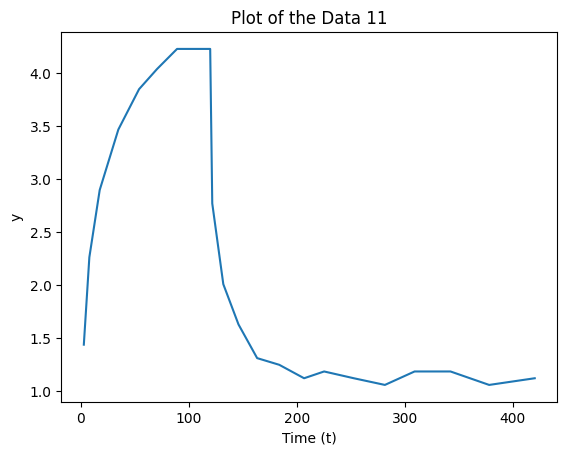

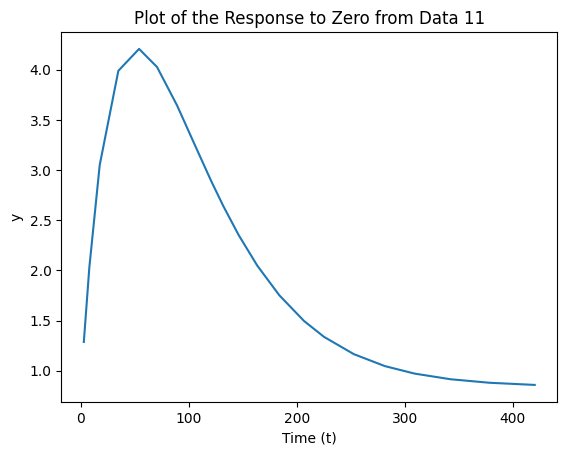

Fitted parameters:  [0.17874384 0.83771706 0.01949568 0.01949567]


In [20]:
# Testing another data set

testFile11 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 1nM", "RU 1nM"])
testFile11 = testFile11.iloc[7:]

# plot the data
plt.plot(testFile11["Time 1nM"], testFile11["RU 1nM"])
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Data 11')
plt.show ()

# Initial guess for the parameters
y_initial = testFile11.iloc[0, 1]
y_final = testFile11["RU 1nM"].iloc[-1]  # Extract the single value
initial_guess = [1, y_initial, 0.08, 0.09]

# data
t_data = testFile11["Time 1nM"]
response_data = testFile11["RU 1nM"]
param_k, pcov_k = curve_fit(response_to_zero, t_data, response_data, p0=initial_guess)

# plot the response to zero fitted data
fitted_response= response_to_zero(testFile11["Time 1nM"], *param_k)
plt.plot(testFile11["Time 1nM"], fitted_response, label='Fitted Data')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Response to Zero from Data 11')
plt.show ()
print("Fitted parameters: ", param_k)


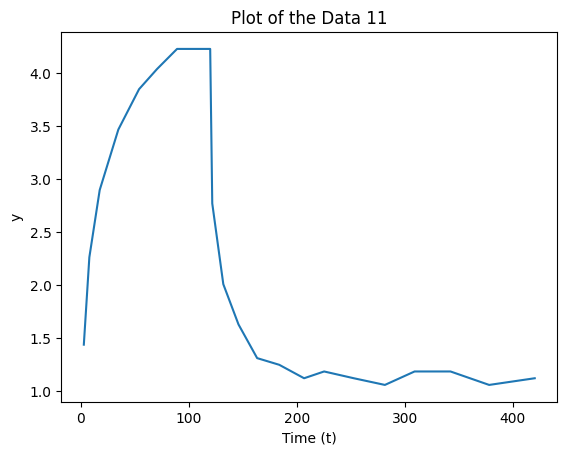

[1, np.float64(1.44), 0.08, 0.09]
[0.17874447 0.83771095 0.01949596 0.01949522]


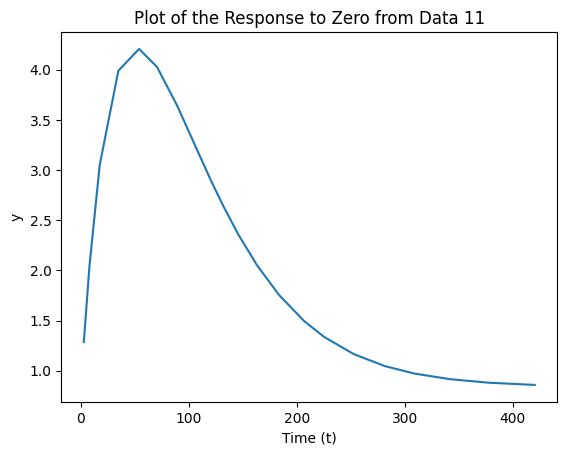

Fitted parameters:  [0.17874447 0.83771095 0.01949596 0.01949522]


In [ ]:
# Testing second data set with overall function

testFile11 = importCleanData("VEGFA165_NRP1_0.5-8nM_Lu2023.xlsx", "sheet1", ["Time 1nM", "RU 1nM"])
testFile11 = testFile11.iloc[7:]

# plot the data
plt.plot(testFile11["Time 1nM"], testFile11["RU 1nM"])
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Data 11')
plt.show ()

# Initial guess for the parameters
y_initial = testFile11.iloc[0, 1]
y_final = testFile11["RU 1nM"].iloc[-1]  # Extract the single value
initial_guess = [1, y_initial, 0.08, 0.09]

# data
t_data = testFile11["Time 1nM"]
response_data = testFile11["RU 1nM"]
param_k, pcov_k = fit_data(t_data, response_data, p0 = initial_guess)

# plot the response to zero fitted data
fitted_response= response_to_zero(testFile11["Time 1nM"], *param_k)
print(initial_guess)
print(param_k)
plt.plot(testFile11["Time 1nM"], fitted_response, label='Fitted Data')
plt.xlabel('Time (t)')
plt.ylabel('y')
plt.title('Plot of the Response to Zero from Data 11')
plt.show ()
print("Fitted parameters: ", param_k)

# Plotting the fit to a plot of the data

In [2]:
# Data Reporting

def plot_data(fitted_response, time_pt, response_data, function, fitted_param, label):
    """
    This function plots the data and the fitted data on the same graph against time

    Parameters
    ----------
    fitted_response : pandas dataframe
        The dataframe containing the time and response values
    time_pt : string
        The column name of the time values
    response_data : string
        The column name of the response values
    function : function
        The function that was used to fit the data
    fitted_param : list
        The parameters of the function
    label : string
        The label of the data

    Returns
    -------
    None
    """
    #plt.plot(fitted_response[time_pt], fitted_response[response_data], label='Fitted Data')
    #plt.xlabel('Time (t)')
    #plt.ylabel('y')
    #plt.title('Plot of the ' + label + ' from Data')
    #plt.show ()
    #print("Fitted parameters: ", fitted_param)
    # Plot the original data
plt.plot(testFile11["Time 1nM"], testFile11["RU 1nM"], 'o', label='Experimental Data')

fitted_response = response_to_zero(testFile11["Time 1nM"], *param_k)
plt.plot(testFile11["Time 1nM"], fitted_response, '-', label='Fitted Curve')


plt.xlabel('Time (t)')
plt.ylabel('Response')
plt.title('Data and Fitted Curve for Data 11')


plt.legend()


plt.show()


print("Fitted parameters: ", param_k)

NameError: name 'testFile11' is not defined